In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [13]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1
n_folds = 5

In [14]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [15]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)
print(SR_left, SR_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
9.0 10.6
upsilon_OS


# Load in the original data

In [16]:
# # load in the data corresponding to the train id
# # we actually want the "test band" here -- train is just for flow
# with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
#     test_data_dict = pickle.load(infile)

# with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
#     configs = infile.readlines()[0].decode("utf-8")
    
#     feature_set = [x.strip() for x in configs.split("'")][1::2]

# print(f"Feature Set: {feature_set}")

## Load in the BDT results

In [17]:

print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8/
Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [18]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot histograms for a small number of FPR thresholds

In [19]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [20]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [21]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    if fit_type == "cubic": degree = 3
    elif fit_type == "quintic": degree = 5
    elif fit_type == "septic": degree = 7

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    # Get a list of all possible cuts for the feature


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        

                    # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
    
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt)

        # test_statistic(masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, ONE_SIDED = True, verbose = False)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        total_events = len(filtered_masses)



        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:141: SyntaxWarning: invalid escape sequence '\m'
<>:141: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1255060/3679944711.py:141: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


Saved Data to plot_data/upsilon_OS_histogram_data_quintic_12.pickle


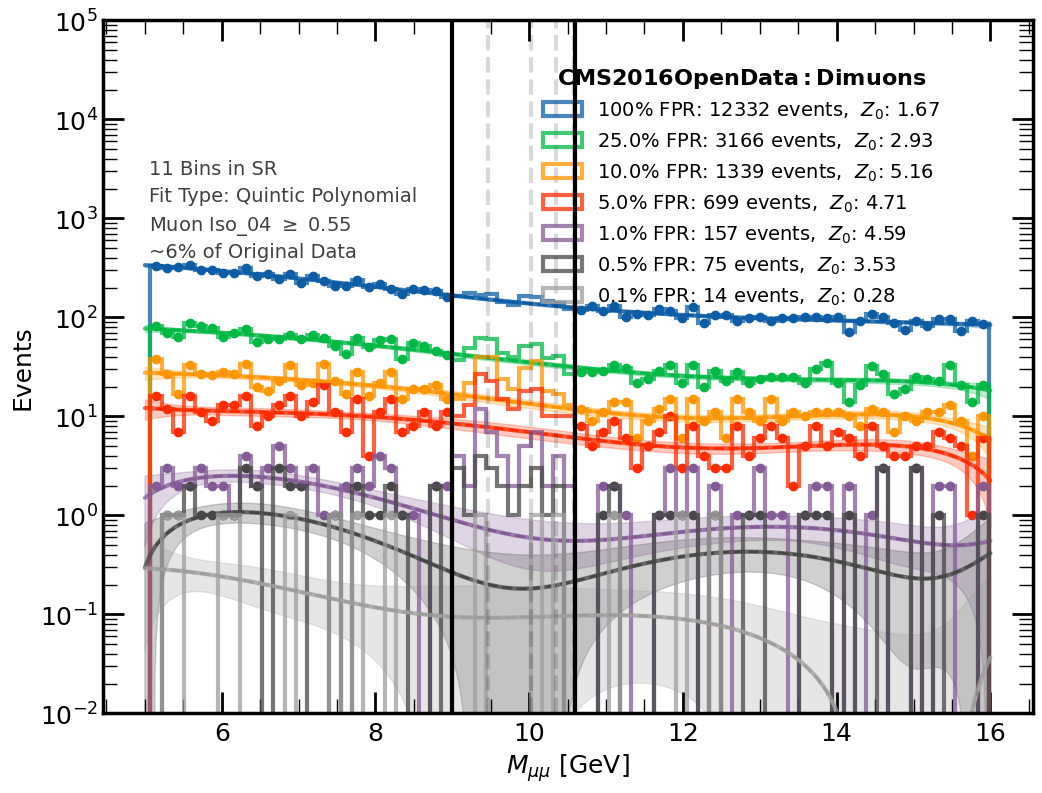

In [22]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
pseudo_e_to_plot = 0
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"upsilon OS\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

print("Saved Data to " + f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle")

/tmp/ipykernel_1255060/3679944711.py:141: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:383: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,4))+", $S/\sqrt{B}$: "+str(round(significance,4))
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:395: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)


KeyboardInterrupt: 

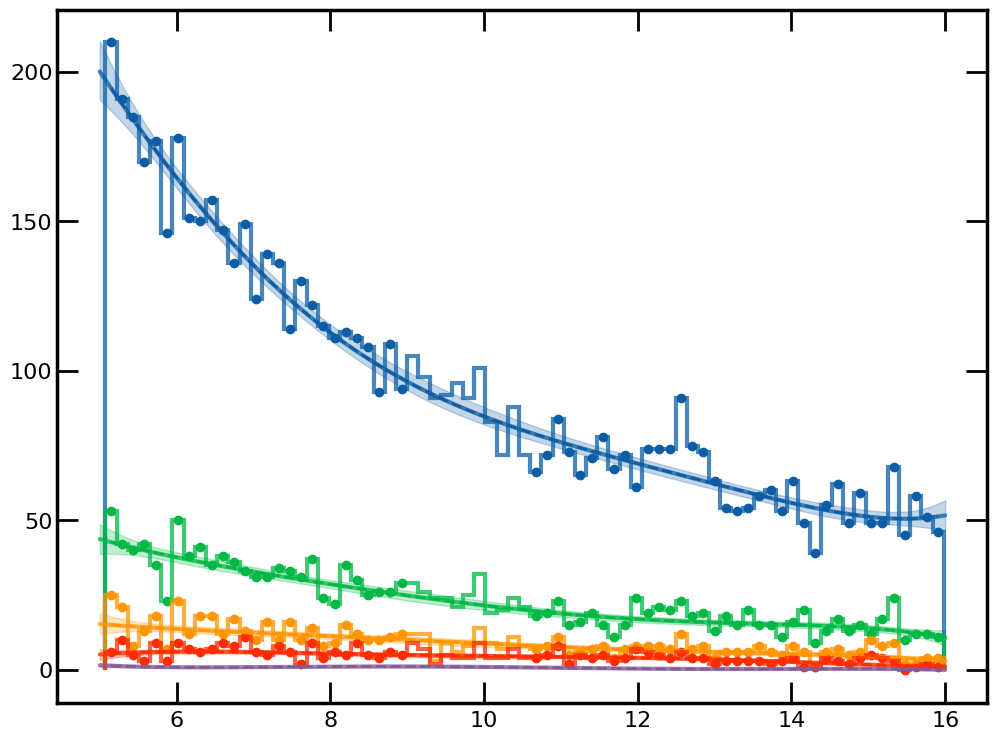

In [23]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"upsilon SS",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


In [129]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

In [130]:
# """
# PLOT HISTOGRAM ON FLOW SAMPLES
# """
# plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Feature Plots

In [ ]:
def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):


    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["features"] = []

    n_features = len(feature_set) - 1
    nbins = 40

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }

    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))
    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
                 
            loc_in_SR_indices =  (loc_true_masses >= SR_left) & (loc_true_masses <= SR_right) 
            loc_score_indices = (loc_scores >= score_cutoffs_by_fold[i_fold][threshold])
            
            loc_pass_indices = loc_in_SR_indices.reshape(-1,) & loc_score_indices.reshape(-1,)
            
            for i_feat in range(n_features):
                # undo the scaling
                selected_features = scaled_to_physical_transform(data_dict_by_fold[i_fold][:,i_feat], preprocessing_info[feature_set[i_feat]])
                filtered_features[i_feat].append(selected_features[loc_pass_indices])
                
        for i_feat in range(n_features):
            filtered_features[i_feat] = np.concatenate(filtered_features[i_feat])   

        save_data["features"].append(filtered_features)

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"
            


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(1e-1, 5*1e2)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (1.05, 0.4), fontsize = 16)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)

In [ ]:
save_data = plot_features(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, SR_left, SR_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_feature_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

In [ ]:
def plot_features(save_data, colors, alphas):


    fpr_thresholds = save_data["fpr_thresholds"]
    filtered_features_all = save_data["features"]


    n_features = len(feature_set) 
    nbins = 50

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }

    
    
    fig, ax = newplot("column", width = 9, height = 3, subplot_array=(1, n_features))
    # fig, ax = plt.subplots(1, n_features, figsize = (9, 3))
    
    for t, threshold in enumerate(fpr_thresholds):

        filtered_features = filtered_features_all[t]
        
   
        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"\% FPR"


            

            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 2, histtype = "step", color = colors[t],label = label_string, alpha = alphas[t])
            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 2, histtype = "stepfilled", color = colors[t], alpha = 0.03)
            ax[i_feat].set_yscale("log")

            if i_feat == 0:
                ax[i_feat].set_xlim(10, 150)
                ax[i_feat].set_xticks([0, 50, 100, 150])

            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(5e-1, 1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])

    starting_x = 0.075
    starting_y = 0.955
    delta_y = 0.05
    text_alpha = 0.75

    line0 = r"Opposite Sign: $\mu^+\mu^-$"
    line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
    line2 = f"Fit Type: {fit_type.capitalize()}"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"16.4fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    if line0 is not None:
        ax[1].text(starting_x, starting_y - (0) * delta_y, r"$\texttt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVt}$", transform=ax[1].transAxes, fontsize=7, verticalalignment='top', alpha = text_alpha, zorder = 10)
        ax[1].text(starting_x, starting_y - (1) * delta_y, line0, transform=ax[1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    ax[2].text(starting_x, starting_y - 0 * delta_y, line1, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 1 * delta_y, line2, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 2 * delta_y, line3, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 3 * delta_y, line4, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$"
    plt.title(title, fontsize = 10, loc = "right")
           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    ax[0].legend(loc = "upper right", fontsize = 8)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)



    return save_data2

# Classical Studies

In [131]:
# from helpers.plotting import feature_bins


# def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
#     """
#     Plot the feature cuts for the given data, scores, and score cutoffs.

#     Parameters
#     ----------
#     feature : str
#         The feature to plot the cuts for.
#     fpr_thresholds : list
#         The list of FPR thresholds to plot.
#     test_data_dict : dict
#         The dictionary of test data.
#     mass_scalar : sklearn.preprocessing.StandardScaler
#         The mass scaler.
#     fit_type : str
#         The type of fit to use for the background.
#     title : str
#         The title of the plot.
#     SB_left : float
#         The left side of the sideband.
#     SR_left : float
#         The left side of the signal region.
#     SR_right : float
#         The right side of the signal region.
#     SB_right : float
#         The right side of the sideband.
#     """

        
#     save_data = {}
#     save_data["fpr_thresholds"] = fpr_thresholds
#     save_data["fit_type"] = fit_type
#     save_data["num_bins_SR"] = num_bins_SR
#     save_data["popts"] = []
#     save_data["pcovs"] = []
#     save_data["significances"] = []
#     save_data["filtered_masses"] = []
#     save_data["y_vals"] = []

#     # Unpack the data dictionary to extract the feature of interest 
#     feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
#     feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
#     feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

#     if flip:
#         feature_SBL = -feature_SBL
#         feature_SR = -feature_SR
#         feature_SBH = -feature_SBH

#     # Unpack the data dictionary to extract the dimuon mass spectrum
#     mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

#     # Get a list of all possible cuts for the feature
#     feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

#     # For each cut, calculate the number of signal and background events in the SR
#     num_in_SBL = []
#     num_in_SR = []
#     num_in_SBH = []
#     FPR = []
#     for cut in feature_cut_points:
#         num_in_SBL.append(np.sum(feature_SBL >= cut))
#         num_in_SR.append(np.sum(feature_SR >= cut))
#         num_in_SBH.append(np.sum(feature_SBH >= cut))


#         # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
#         # FPR is the combination of SBH and SBL
#         FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
#     # Set up fit types
#     if fit_type == "cubic": fit_function = bkg_fit_cubic
#     elif fit_type == "quintic": fit_function = bkg_fit_quintic
#     elif fit_type == "septic": fit_function = bkg_fit_septic

#     plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

#     fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


#     # fig, ax = newplot("full", aspect_ratio = 1.5)
#     fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
#     for t, threshold in enumerate(fpr_thresholds):


#         # Use interpolation to find the cut point that gives the desired FPR
#         best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

#         # Make the cuts to both the feature and the mass
#         feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
#         feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
#         feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

#         mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
#         mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
#         mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

#         # Concatenate to get the full mass spectrum
#         filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

#         # get the fit function to SB background
#         # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
#         popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
#         #print("chi2/dof:", chi2/n_dof)
        
#         # plot the fit function
#         plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

#         # calculate significance of bump
#                 # calculate significance of bump
#         if ONE_SIDED:
#             num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
#             q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)


#             y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
#             B_error = np.sqrt(np.sum(y_err**2))
#             S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

            

#         label_string = str(round(100*threshold, 2))+"% FPR: "+str(len(feature_SBL_cut)+len(feature_SR_cut)+len(feature_SBH_cut))+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))


#         hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
#         # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
#         plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


#         save_data["popts"].append(popt)
#         save_data["pcovs"].append(pcov)
#         save_data["significances"].append(np.sqrt(q0))
#         save_data["filtered_masses"].append(filtered_masses)
#         save_data["y_vals"].append(y_vals)

#     line1 = f"{num_bins_SR -1 } Bins in SR"
#     line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
#     line3 = r"Muon Iso_04 $\geq$ 0.55"
#     line4 = r"~6% of Original Data"

#     starting_x = 0.475
#     starting_y = 0.45
#     delta_y = 0.04
#     text_alpha = 0.75
#     ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


#     legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$: "+feature
#     plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


#     plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
#     plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

#     plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
#     plt.ylabel("Events", fontsize = 18)

#     # plt.yscale("log")
#     plt.ylim(0.5, 1e3)

#     # Add more x ticks (major and minor)
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
#     plt.minorticks_on()
#     plt.tick_params(axis='x', which='minor', bottom=True)
#     plt.tick_params(axis='y', which='minor', left=True)

#     plot_upsilon_resonances(ax)

#     return save_data


In [132]:
# flip_features = [False, True, True]
# for feature in feature_set[:-1]:
#     print(feature)
#     save_data =  plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])
#     with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
#         pickle.dump(save_data, ofile)


In [133]:
n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff



n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff


        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):

    if fit_type == "cubic": degree = 3
    if fit_type == "quintic": degree = 5
    if fit_type == "septic": degree = 7
            

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

             # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances



In [134]:
test = all_alt_data_splits[0]["alt"][0]
print(test)

test = all_test_data_splits[0]
print(test.keys())

[[-0.30334359 -1.15857506  3.35292578  0.43714195]
 [-0.23972486 -0.37708494 -0.42117029  0.15533382]
 [-0.47238263 -0.83464962  0.1226217  -1.02116442]
 ...
 [ 1.23497939 -0.30098721  1.10236311  0.2833088 ]
 [ 0.72366327 -0.29456356  1.24911141  1.69428086]
 [ 0.77595931 -0.07558635 -1.2014364  -1.16374636]]
dict_keys([0, 1, 2, 3, 4])


In [135]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]


print(all_scores_splits.keys())

dict_keys([0])


In [136]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)


significances_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)




On pseudo experiment 1...
S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  107.91602253361862 B:  1196.0839774663814 sqrt(q0):  2.1614754491605943
S:  99.10196524872924 B:  923.8980347512708 sqrt(q0):  2.392690891129234
S:  127.49988449390594 B:  670.5001155060941 sqrt(q0):  3.1047438483838983
S:  108.54564042866468 B:  523.4543595713353 sqrt(q0):  2.9901103215772946
S:  105.94424322675877 B:  387.0557567732412 sqrt(q0):  3.345370584119417
S:  117.2029541234163 B:  277.7970458765837 sqrt(q0):  4.2202016983932955
S:  137.06943385754735 B:  203.93056614245265 sqrt(q0):  5.5378380087906915
S:  113.26412594142582 B:  161.73587405857418 sqrt(q0):  5.161746960608437
S:  109.79610205353504 B:  116.20389794646496 sqrt(q0):  5.639844022251574
S:  81.84877977156476 B:  96.15122022843524 sqrt(q0):  4.761494382824935
S:  73.42726669259369 B:  79.57273330740631 sqrt(q0):  5.34603528233096
S:  66.15488635660037 B:  57.84511364339963 sqrt(q0):  4.812663557653308
S:  65.12

In [137]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """


    if fit_type == "cubic": degree = 3
    if fit_type == "quintic": degree = 5
    if fit_type == "septic": degree = 7


    num_experiments = num_pseudoexperiments
    fpr_thresholds = fpr_thresholds_finegrained
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])
        

        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]

        # mean = np.nanmean(feature_of_interest)
        # feature_of_interest = np.nan_to_num(feature_of_interest, nan = mean)

        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]

        # mean = np.nanmean(masses)
        # masses = np.nan_to_num(masses, nan = mean)

        if flip:
            feature_of_interest = -feature_of_interest
           

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]




        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]

        # print(mass_SBL.shape, mass_SR.shape, mass_SBH.shape)
        # print(feature_SBL.shape, feature_SR.shape, feature_SBH.shape)

        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


        # Set up fit types
        if fit_type == "cubic": fit_function = bkg_fit_cubic
        elif fit_type == "quintic": fit_function = bkg_fit_quintic
        elif fit_type == "septic": fit_function = bkg_fit_septic


        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]
            # print(np.min(feature_of_interest), np.max(feature_of_interest), best_feature_cut)

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

    

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]


            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
           
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

    
    return significances


In [138]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [False, True, True, False] 



#"dimu_pt", "mu0_ip3d", "mu1_ip3d", 
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, fit_type, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

  
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, fit_type, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  55.4637943024245 B:  1251.5362056975755 sqrt(q0):  1.0207971769350788
S:  69.3473775710055 B:  973.6526224289945 sqrt(q0):  1.4418333030874528
S:  127.4757554762042 B:  727.5242445237958 sqrt(q0):  3.0055013414197065
S:  106.58837752304441 B:  552.4116224769556 sqrt(q0):  2.8725373099011806
S:  93.01214156447207 B:  433.9878584355279 sqrt(q0):  2.843373878976206
S:  83.85746632857791 B:  318.1425336714221 sqrt(q0):  2.973527359695709
S:  67.16716372687816 B:  239.83283627312184 sqrt(q0):  2.726514186633374
S:  59.94710164426746 B:  174.05289835573254 sqrt(q0):  2.7948503448433364
S:  47.176210840102016 B:  126.82378915989798 sqrt(q0):  2.5669867912270754
S:  39.45815347959932 B:  99.54184652040068 sqrt(q0):  2.423729517404336
S:  23.31217222569974 B:  78.68782777430026 sqrt(q0):  1.65534959513688
S:  16.29685768175807 B:  60.70314231824193 sqrt(q0):  1.3325963753636578
S:  7.849044538736706 B:  51.15095546126

100%|██████████| 1/1 [02:45<00:00, 165.98s/it]


S:  0.29432784285723335 B:  2.7056721571427667 sqrt(q0):  0.17582900027652337
mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  103.47429104173193 B:  1183.525708958268 sqrt(q0):  1.926227694281896
S:  105.55480106673042 B:  885.4451989332696 sqrt(q0):  2.2558429946595755
S:  128.2367959967978 B:  661.7632040032022 sqrt(q0):  3.119311049615627
S:  107.33872963022901 B:  507.661270369771 sqrt(q0):  2.978000964751406
S:  87.41720801811437 B:  377.58279198188563 sqrt(q0):  2.8010529541852955
S:  64.09845692301695 B:  284.90154307698305 sqrt(q0):  2.374706598375613
S:  65.6199673239586 B:  202.3800326760414 sqrt(q0):  2.799531636427694
S:  68.38855503339846 B:  149.61144496660154 sqrt(q0):  3.305612902012051
S:  66.4923537985881 B:  109.5076462014119 sqrt(q0):  3.910719203510536
S:  61.8217714196614 B:  75.1782285803386 sqrt(q0):  3.9410835754975593
S:  49.36845650717334 B:  56.63154349282666 sqrt(q0):  3.9244218642361917
S:  47.533977872742675 B:  39.466022127257325 sqrt(q0):  3.9429594766239435
S:  37.07383438375659 B:  28.9261656162434

100%|██████████| 1/1 [02:53<00:00, 173.08s/it]


S:  0.7739785222664599 B:  2.22602147773354 sqrt(q0):  0.4923698169943162
mu1_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  113.31889416258923 B:  1207.6811058374108 sqrt(q0):  2.0976442343177815
S:  127.13473552635469 B:  884.8652644736453 sqrt(q0):  2.7139897736445793
S:  122.43231651634642 B:  675.5676834836536 sqrt(q0):  2.9864770053581347
S:  125.21406808854249 B:  512.7859319114575 sqrt(q0):  3.476312070659358
S:  96.86588052812874 B:  391.13411947187126 sqrt(q0):  3.0909137263351734
S:  62.548207827138185 B:  314.4517921728618 sqrt(q0):  2.259873281758189
S:  46.836045684277906 B:  224.1639543157221 sqrt(q0):  1.9971957196496328
S:  43.18301218803731 B:  162.8169878119627 sqrt(q0):  2.1313794471081233
S:  37.43669213812983 B:  122.56330786187017 sqrt(q0):  2.1457637307127952
S:  29.13077422530783 B:  97.86922577469217 sqrt(q0):  2.0951824558173198
S:  38.24117590345165 B:  67.75882409654835 sqrt(q0):  2.800465676841494
S:  36.66531625088504 B:  45.33468374911496 sqrt(q0):  3.106023750253901
S:  21.929623409614535 B:  38.070

100%|██████████| 1/1 [02:29<00:00, 149.42s/it]


S:  3.611568449740132 B:  2.388431550259868 sqrt(q0):  1.95712390693584
random


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90822474080028 B:  1608.0917752591997 sqrt(q0):  1.673733937691351
S:  19.530195754709666 B:  1234.4698042452903 sqrt(q0):  0.41575194009308986
S:  37.29191599520232 B:  917.7080840047977 sqrt(q0):  0.8004777885680989
S:  20.1857770870771 B:  701.8142229129229 sqrt(q0):  0.4987992745821995
S:  8.212773746281414 B:  536.7872262537186 sqrt(q0):  0.6387914683284394
S:  0.644003859797408 B:  407.3559961402026 sqrt(q0):  0.023549189085464512
S:  -6.066867168466445 B:  313.06686716846644 sqrt(q0):  0.0
S:  -19.141638560524882 B:  244.14163856052488 sqrt(q0):  0.0
S:  -21.379510007320192 B:  190.3795100073202 sqrt(q0):  0.0
S:  -5.755337921437018 B:  134.75533792143702 sqrt(q0):  0.0
S:  2.124009970903444 B:  101.87599002909656 sqrt(q0):  0.1586052327193111
S:  1.3727528718110023 B:  76.627247128189 sqrt(q0):  0.10421729969615419
S:  -2.0172806431341783 B:  58.01728064313418 sqrt(q0):  0.0
S:  7.12270248265218 B:  41.87729751734782 sqrt(q0):  0.8028760722184604
S:  13.94233639921859 B:

100%|██████████| 1/1 [02:26<00:00, 146.25s/it]


S:  1.899644631205975 B:  0.10035536879402499 sqrt(q0):  1.512693165834368
dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  26.923423170431647 B:  746.0765768295684 sqrt(q0):  0.6442012167269859
S:  2.4427019753767354 B:  588.5572980246233 sqrt(q0):  0.06651873921833816
S:  -11.369386720551688 B:  471.3693867205517 sqrt(q0):  0.0
S:  -4.779587898567456 B:  370.77958789856746 sqrt(q0):  0.0
S:  -0.6893007231867045 B:  277.6893007231867 sqrt(q0):  0.0
S:  3.0497285148338165 B:  216.95027148516618 sqrt(q0):  0.138757182204549
S:  -5.236448237262266 B:  156.23644823726227 sqrt(q0):  0.0
S:  0.660105003800254 B:  121.33989499619975 sqrt(q0):  0.425235818155584
S:  8.868613014696734 B:  85.13138698530327 sqrt(q0):  0.6291661410968746
S:  -0.29244435819490633 B:  60.292444358194906 sqrt(q0):  0.0
S:  3.304428626309459 B:  45.69557137369054 sqrt(q0):  0.31966293033166066
S:  9.108989821058024 B:  28.891010178941976 sqrt(q0):  1.03743870305724
S:  9.990764603200844 B:  23.009235396799156 sqrt(q0):  1.4065058240259882
S:  4.547569562406956 B:  

100%|██████████| 1/1 [02:22<00:00, 142.27s/it]


S:  -0.6917865063063127 B:  0.6917865063063127 sqrt(q0):  0.0
mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  30.22306045396624 B:  714.7769395460338 sqrt(q0):  0.7353230554816076
S:  50.198745847465034 B:  528.801254152535 sqrt(q0):  1.4048168461684931
S:  35.42678019076726 B:  397.57321980923274 sqrt(q0):  1.1463930014442152
S:  -11.092109224228693 B:  327.0921092242287 sqrt(q0):  0.0
S:  -7.149840297896674 B:  235.14984029789667 sqrt(q0):  0.0
S:  -2.798751974312438 B:  171.79875197431244 sqrt(q0):  0.0
S:  -5.799874303602081 B:  120.79987430360208 sqrt(q0):  0.0
S:  7.961259269671515 B:  86.03874073032848 sqrt(q0):  0.5376195648658807
S:  0.971932814381347 B:  65.02806718561865 sqrt(q0):  0.08740918141530915
S:  -1.0747920202530636 B:  52.074792020253064 sqrt(q0):  0.0
S:  -9.83489792689599 B:  44.83489792689599 sqrt(q0):  0.0
S:  -3.8087422989086406 B:  35.80874229890864 sqrt(q0):  0.0
S:  -3.0984209482749243 B:  30.098420948274924 sqrt(q0):  0.0
S:  -7.666120916333071 B:  22.66612091633307 sqrt(q0):  0.0
S:  -4.560

100%|██████████| 1/1 [02:10<00:00, 130.53s/it]


S:  1.4600073463492111 B:  1.5399926536507889 sqrt(q0):  1.0397083300650778
mu1_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  53.79233615436533 B:  710.2076638456347 sqrt(q0):  1.3194185800824831
S:  35.19164993685854 B:  537.8083500631415 sqrt(q0):  0.9884673846775889
S:  22.16528790248043 B:  405.83471209751957 sqrt(q0):  0.7203853065955254
S:  44.13102097068764 B:  289.86897902931236 sqrt(q0):  1.648377214385847
S:  43.00885655553003 B:  215.99114344446997 sqrt(q0):  1.8494730720121955
S:  47.27515085920183 B:  151.72484914079817 sqrt(q0):  2.3698062696803643
S:  25.81833057464415 B:  116.18166942535585 sqrt(q0):  1.5019253828367314
S:  21.732318108560534 B:  82.26768189143947 sqrt(q0):  1.4981540255835606
S:  14.654935054323659 B:  62.34506494567634 sqrt(q0):  1.1623314615770541
S:  11.617247323591073 B:  49.38275267640893 sqrt(q0):  1.0401206563285659
S:  5.107030585661818 B:  37.89296941433818 sqrt(q0):  0.608291651847028
S:  0.626389826774254 B:  27.373610173225746 sqrt(q0):  0.3047656119958899
S:  1.5059461751993446 B:  20.49405

100%|██████████| 1/1 [02:22<00:00, 142.18s/it]


S:  0.017619709461497157 B:  0.9823802905385028 sqrt(q0):  0.017759269488118838
random


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94918055339997 B:  953.0508194466 sqrt(q0):  0.756472185456218
S:  20.925077799692076 B:  704.0749222003079 sqrt(q0):  0.5123814483885977
S:  10.623453083655477 B:  538.3765469163445 sqrt(q0):  0.2982002819947631
S:  -0.5512536934347168 B:  416.5512536934347 sqrt(q0):  0.0
S:  -5.211502443685163 B:  307.21150244368516 sqrt(q0):  0.0
S:  -19.65069572477202 B:  236.65069572477202 sqrt(q0):  0.0
S:  -14.348037383985144 B:  175.34803738398514 sqrt(q0):  0.0
S:  -2.999139961926744 B:  132.99913996192674 sqrt(q0):  0.0
S:  1.6852702573649765 B:  97.31472974263502 sqrt(q0):  0.11110710331198792
S:  4.513610467876063 B:  73.48638953212394 sqrt(q0):  0.5424070394756709
S:  -15.870311783858611 B:  62.87031178385861 sqrt(q0):  0.0
S:  -7.135665248347536 B:  45.135665248347536 sqrt(q0):  0.0
S:  -3.882000305950715 B:  29.882000305950715 sqrt(q0):  0.0
S:  1.3949931719312332 B:  17.605006828068767 sqrt(q0):  0.20113226900934397
S:  -1.6939749304756493 B:  14.69397493047565 sqrt(q0):  0.0
S: 

100%|██████████| 1/1 [02:14<00:00, 134.74s/it]

S:  -0.7971416685665305 B:  0.7971416685665305 sqrt(q0):  0.0


In [139]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


[1.67373394 1.02079718 1.4418333  3.00550134 2.87253731 2.84337388
 2.97352736 2.72651419 2.79485034 2.56698679 2.42372952 1.6553496
 1.33259638 0.72623261 0.19803191 0.20233256 0.         0.10149249
 0.04317877 0.23866742 0.         0.         0.         0.
 0.175829  ]
max observed significance 3.0055013414197065
[1.67373394 1.92622769 2.25584299 3.11931105 2.97800096 2.80105295
 2.3747066  2.79953164 3.3056129  3.9107192  3.94108358 3.92442186
 3.94295948 3.78745902 3.39773195 3.24646349 3.21979237 3.28969346
 1.19679583 0.70400866 1.02194539 0.84953442 0.98873285 0.67232805
 0.49236982]
max observed significance 3.9429594766239435
[1.67373394 2.09764423 2.71398977 2.98647701 3.47631207 3.09091373
 2.25987328 1.99719572 2.13137945 2.14576373 2.09518246 2.80046568
 3.10602375 2.3748456  2.78137324 3.41194738 3.25348382 1.69722237
 2.16184349 1.96323699 1.8512581  1.67210224 1.92249586 1.96010373
 1.95712391]
max observed significance 3.476312070659358
[1.67373394 2.16147545 2.3926908

<>:68: SyntaxWarning: invalid escape sequence '\P'
<>:68: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_43432/215735003.py:68: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

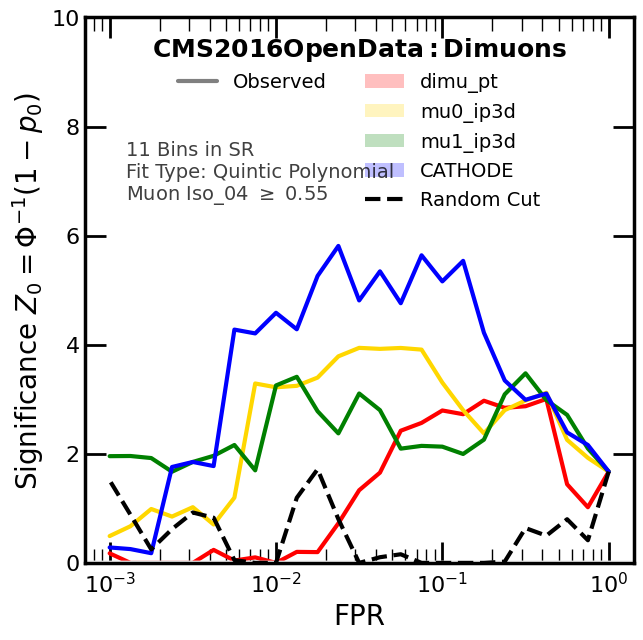

In [140]:
def get_median_percentiles(x_array):
    
    x_median = np.nanmedian(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    print(SIG_observed)
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs[key][:,1:])
    # # SIG_median = SIG_observed
    # # SIG_lower = SIG_observed
    # # SIG_upper = SIG_observed
    # # SIG_2lower = SIG_observed
    # # SIG_2upper = SIG_observed

    # print(key)
    # index = 0
    # print("max observed significance", np.max(SIG_observed))
    # print("Original Significance", SIG_observed[index])
    # print("Median significance", SIG_median[index])
    # print("+1sigma significance", SIG_lower[index], SIG_upper[index])
    # print("+2sigma significance", SIG_2lower[index], SIG_2upper[index])

    # print("Percent of 0", np.sum(feature_SIGs[key][index,1:] == 0)/len(feature_SIGs[key][index,1:]))
    

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    # ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

    print("max observed significance", np.max(SIG_observed))

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)

<>:48: SyntaxWarning: invalid escape sequence '\P'
<>:48: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_43432/110416016.py:48: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

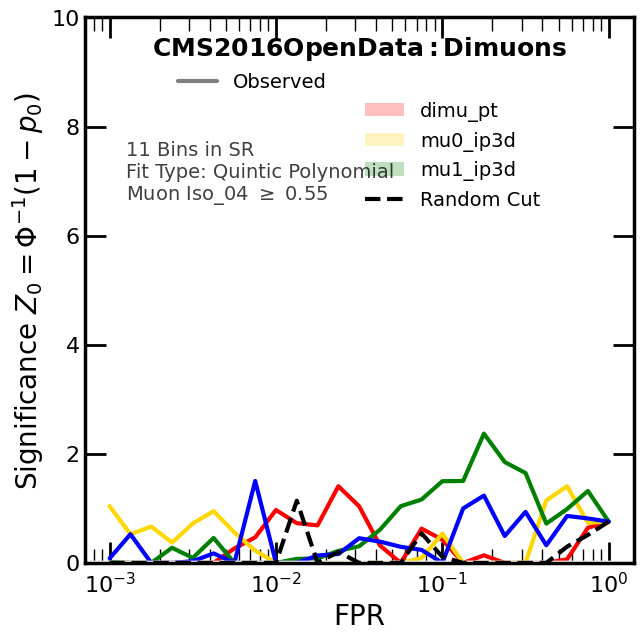

In [141]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue", "black"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt[key][:,1:])
    # SIG_median = SIG_observed
    # SIG_lower = SIG_observed
    # SIG_upper = SIG_observed
    # SIG_2lower = SIG_observed
    # SIG_2upper = SIG_observed
    


    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    if key == "random":
        ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = colors[i], alpha = 0.5)
        # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
        # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])


# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




